# Linear regression, Lab 1
Made by Louis Dumontet and Victor Serena

## Importing tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from keras.layers import Input, Add, Dense
from keras.models import Sequential
import tensorflow as tf

## Loading the dataset

In [2]:
df = pd.read_excel('dataset/Folds5x2_pp.xlsx')

## Familiarizing with the dataset

In [3]:
print("Size of our dataframe :",df.shape[0])
print()
df.describe()

Size of our dataframe : 9568



,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [4]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [5]:
df.tail()

,AT,V,AP,RH,PE
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74
9567,21.60,62.52,1017.23,67.87,453.28


# Functions to compute the models

## Split function
Split the dataset in 2sets, train and test with test being composed of random rows taken from the dataset

In [6]:
def split(dataframe, test_size = 0.2) :
    
    """Split the dataframe in train and test"""
    
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    
    size = dataframe.shape[0]
    
    # train size is size of the (1-test_size)*100 percent of the dataframe that was sampled before
    train_size = int(size * (1 - test_size))
    
    train = dataframe[:train_size]
    
    test = dataframe[train_size:]
    
    return train, test

## Normalize features
Using the z-score method

In [7]:
def normalize_dataframe(dataframe) :
    
    """Normalize and return dataframe"""
    
    # we used the z-score normalisation method
    dataframe = (dataframe - dataframe.mean()) / dataframe.std()
    
    return dataframe

## Initialize weights
All weights are set to 0

In [8]:
def weights_initializer(dataframe):
    
    """Creation of the weight vector according to the size of the dataset"""
    
    # we initialized our weights to 0
    weights = np.zeros((dataframe.shape[1],1))
    
    return weights

## Create the X matrix with bias

In [9]:
def create_matrix(dataframe, column) : 
    
    """Creation of the matrix of observations from a dataframe"""
    
    # drop the label colum that we want to predict
    df_without_column = dataframe.drop(column, axis=1)
    
    matrix = df_without_column.to_numpy()
    
    # add the bias column to the dataset
    matrix = np.c_[np.ones(matrix.shape[0]), matrix]
    
    return matrix

## Create the y matrix (column)

In [10]:
def create_labels(dataframe, column) :
    
    """Creation of the labels vector"""
    
    labels = dataframe[column].to_numpy().T
    
    labels.shape = (dataframe.shape[0], 1)
    
    return labels

## Compute the cost function using matrices multiplication

In [11]:
def cost_function(matrix, weights, labels) :
    
    """Compute the cost function"""
    
    m = matrix.shape[0]
    
    # this is the computation of the cost function using matrix multiplication
    J = (1 /(2 * m)) * (matrix @ weights - labels).T @ ((matrix @ weights) - labels)
    
    return J[0][0]

## Update the new weight vector

In [12]:
def gradient_descent(matrix, weights, labels, learning_rate = 0.03):
    
    """Update and return the weights"""
    
    m = matrix.shape[0]
    
    # compute new weight vector given the learning rate and previous weights
    weights = weights - learning_rate / m * (matrix.T @ (matrix @ weights - labels))
    
    return weights

## Compute final weights and cost list using gradient descent

In [13]:
def gradient_descent_from_dataframe(dataframe, labels_column, delta=0, learning_rate = 0.03, iterations = 1000, normalize = True) : 
    
    # cost list that will help us check that our cost is indeed decreasing
    cost_list = []

    if normalize :
        dataframe = normalize_dataframe(dataframe)
    
    # intialize everything using the previous functions
    weights = weights_initializer(dataframe)
    
    matrix = create_matrix(dataframe, labels_column)
    
    labels = create_labels(dataframe, labels_column)
    
    cost = cost_function(matrix, weights, labels)
    
    cost_list.append(cost)
    
    # execute the gradient descent, stop when the max number of iterations is reached or when the cost is sufficiently low
    for i in range(iterations - 1) :
        
        weights = gradient_descent(matrix, weights, labels, learning_rate)
        
        new_cost = cost_function(matrix, weights, labels)
        
        cost_list.append(new_cost)
        
        if abs(new_cost - cost) < delta :
            
            break
        
        cost = new_cost
        
    return weights, cost_list

## Compute final weights using normal equation

In [14]:
def normal_equation_from_dataframe(dataframe, labels_column, normalize=True) :
    
    if normalize :
        # once again normalize the dataframe in order to compare comparable costs
        # in this instance costs from our gradient descent with costs from the normal equation
        dataframe = normalize_dataframe(dataframe) 
    
    matrix = create_matrix(dataframe, labels_column)
    
    labels = create_labels(dataframe, labels_column)
    
    weights = np.linalg.pinv( matrix.T @ matrix ) @ matrix.T @ labels
    
    print("Cost :",cost_function(matrix, weights, labels))
    
    return weights

## Compute the MAE and RMSE given weights

In [15]:
def compute_metrics(dataframe, labels_column, weights, normalize=True) :
    
    if normalize:
        dataframe_normalized = normalize_dataframe(dataframe)
        meandf = dataframe[labels_column].mean()
        stddf = dataframe[labels_column].std()
        
    else :
        dataframe_normalized = dataframe
        meandf = 0
        stddf = 1
    
    matrix = create_matrix(dataframe_normalized, labels_column)
    
    labels = create_labels(dataframe, labels_column)
    
    m = matrix.shape[0]
    
    yhat = stddf * (matrix @ weights) + meandf
    
    mae = np.sum( abs(yhat - labels) ) / m
    
    rmse = np.sqrt( np.sum( (yhat - labels)**2 ) / m )
    
    print("MAE :",mae)
    
    print("RMSE :",rmse)
    
    return mae, rmse

## Compute the linear correlation coefficient

In [16]:
def compute_R2(dataframe, labels_column, weights, normalize=True) :
    
    if normalize:
        dataframe_normalized = normalize_dataframe(dataframe)
        meandf = dataframe[labels_column].mean()
        stddf = dataframe[labels_column].std()
        
    else :
        dataframe_normalized = dataframe
        meandf = 0
        stddf = 1
    
    matrix = create_matrix(dataframe_normalized, labels_column)
    
    labels = create_labels(dataframe, labels_column)
    
    mean_labels = labels.mean()
    
    m = matrix.shape[0]
    
    yhat = stddf * (matrix @ weights) + meandf
    
    sst = np.sum( (labels - mean_labels)**2 )
    
    ssr = np.sum( (yhat - labels)**2 ) 
    
    R2 = 1 - (ssr / sst)
    
    print("R² :",R2)
    
    return R2

#### The previous metrics, R², MAE and RMSE, are use to verify the efficiency of each model

## Execute the gradient descent model

In [17]:
def model_gradient_descent(dataframe, labels_column, normalize=True, delta=0, learning_rate = 0.03, iterations = 1000, 
                           test_split=0.2) :
    
    train, test = split(dataframe, test_split)
    
    weights, cost_list = gradient_descent_from_dataframe(train, labels_column, delta, learning_rate, iterations, normalize)
    
    print("Results with gradient descent :")
    print()
    
    print("Hyperparameters : ")
    print("Learning rate :",learning_rate," Numbers of iterations :",iterations," Delta :",delta,
          " Size of the test set :",test_split * 100,"%")
    print()
    
    plt.title("Cost over iterations")
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost")
    plt.plot(cost_list)
    plt.show()
    
    print("MAE and RMSE on the entire dataset :")
    fullMetrics = compute_metrics(dataframe, labels_column, weights)
    print()
    
    print("MAE and RMSE on the training set :")
    trainMetrics = compute_metrics(train, labels_column, weights)
    print()
    
    print("MAE and RMSE on the test set :")
    testMetrics = compute_metrics(test, labels_column, weights)
    print()
    
    print("R² on the entire dataset :")
    fullR2 = compute_R2(dataframe, labels_column, weights, normalize)
    print()
    
    print("R² on the training set :")
    trainR2 = compute_R2(train, labels_column, weights, normalize)
    print()
    
    print("R² on the test set :")
    testR2 = compute_R2(test, labels_column, weights, normalize)
    print()
    
    return weights,fullMetrics,trainMetrics,testMetrics,fullR2,trainR2,testR2

## Execute the normal equation model

In [18]:
def model_normal_equation(dataframe, labels_column, normalize=True, test_split=0.2) :
    
    train, test = split(dataframe, test_split)
    
    print("Results with normal equation :")
    print()
    
    print("Hyperparameters : ")
    print("Size of the test set :",test_split * 100,"%")
    print()
    
    weights = normal_equation_from_dataframe(train, labels_column, normalize)

    print()
    print("MAE and RMSE on the entire dataset :")
    fullMetrics = compute_metrics(dataframe, labels_column, weights, normalize)
    print()
    
    print("MAE and RMSE on the training set :")
    trainMetrics = compute_metrics(train, labels_column, weights, normalize)
    print()
    
    print("MAE and RMSE on the test set :")
    testMetrics = compute_metrics(test, labels_column, weights, normalize)
    print()
    
    print("R² on the entire dataset :")
    fullR2 = compute_R2(dataframe, labels_column, weights, normalize)
    print()
    
    print("R² on the training set :")
    trainR2 = compute_R2(train, labels_column, weights, normalize)
    print()
    
    print("R² on the test set :")
    testR2 = compute_R2(test, labels_column, weights, normalize)
    print()
    
    return weights,fullMetrics,trainMetrics,testMetrics,fullR2,trainR2,testR2

## Execute the model with scikit learn

In [19]:
def model_with_scikit(dataframe, labels_column, normalize=True) :
    
    model = LinearRegression()
    normalize = MinMaxScaler()

    Y = dataframe[labels_column]

    if normalize:
        X = normalize.fit_transform(dataframe.drop([labels_column], axis=1))
    else :
        X = dataframe.drop(labels_column)

    model.fit(X, Y)
    predictions = model.predict(X)
    print("MAE :",mean_absolute_error(Y, predictions))
    print("RMSE :",mean_squared_error(Y, predictions, squared=False))
    print("R² :",model.score(X, Y))

#### Once we have defined all of the model we can now display the results

## Display the results

Results with gradient descent :

Hyperparameters : 
Learning rate : 0.03  Numbers of iterations : 1000  Delta : 0  Size of the test set : 20.0 %



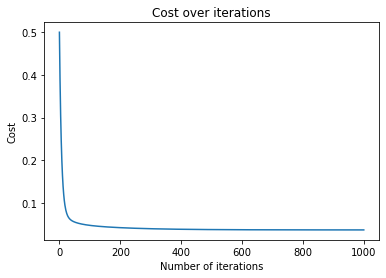

MAE and RMSE on the entire dataset :
MAE : 3.6305219275247635
RMSE : 4.559872513372374

MAE and RMSE on the training set :
MAE : 3.6484526612377013
RMSE : 4.606886594290374

MAE and RMSE on the test set :
MAE : 3.5550742291596924
RMSE : 4.359780212349255

R² on the entire dataset :
R² : 0.9286101167839966

R² on the training set :
R² : 0.9271047865455152

R² on the test set :
R² : 0.9348267591700142



In [20]:
(gradientWeights, gradientFullMetrics, gradientTrainMetrics, gradientTestM, 
 gradientFullR2, gTrainR2, gradientTestR2) = model_gradient_descent(df, 'PE')

In [21]:
(normalWeights, normalfullMetrics, normaltrainMetrics, normaltestMetrics,
 normalfullR2, normaltrainR2, normaltestR2) = model_normal_equation(df, 'PE')

Results with normal equation :

Hyperparameters : 
Size of the test set : 20.0 %

Cost : 0.036845623864481904

MAE and RMSE on the entire dataset :
MAE : 3.6272106186581
RMSE : 4.557319754655205

MAE and RMSE on the training set :
MAE : 3.669088329721872
RMSE : 4.634656720641238

MAE and RMSE on the test set :
MAE : 3.4583175051363364
RMSE : 4.233183404102199

R² on the entire dataset :
R² : 0.9286900269718481

R² on the training set :
R² : 0.9262991232043005

R² on the test set :
R² : 0.9382881330180264



In [22]:
train, test = split(df, 0.2)

print("Results with scikit learn :")

print()
print("On the entire dataset :")
model_with_scikit(df, 'PE')
print()
print("On the train set :")
model_with_scikit(train, 'PE')
print()
print("On the test set :")
model_with_scikit(test, 'PE')

Results with scikit learn :

On the entire dataset :
MAE : 3.6252158076011827
RMSE : 4.557126016749484
R² : 0.9286960898122536

On the train set :
MAE : 3.5877665521613964
RMSE : 4.499767312633663
R² : 0.9304697993335613

On the test set :
MAE : 3.7701397363854507
RMSE : 4.777141027197321
R² : 0.9216823302397441


# Conclusion Lab 1 :

### As we can see the results from the 3 models are very similar and with our gradient descent, our normal equation and scikit learn. So, we can strongly affirm that our gradient descent implementation works

# Lab 2 :

We will perform the same approach as the first lab

## Familiarizing with the dataset

In [23]:
df_day = pd.read_csv('dataset/day.csv')
df_hour = pd.read_csv('dataset/hour.csv')

df_day.drop(['casual', 'registered', 'dteday', 'instant', 'atemp'], axis=1, inplace=True)
df_hour.drop(['casual', 'registered', 'dteday', 'instant', 'atemp'], axis=1, inplace=True)

In [24]:
print('Shape of the dataframe:',df_hour.shape)
df_hour.head()

Shape of the dataframe: (17379, 12)


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


In [25]:
df_hour.tail()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
17374,1,1,12,19,0,1,1,2,0.26,0.60,0.1642,119
17375,1,1,12,20,0,1,1,2,0.26,0.60,0.1642,89
17376,1,1,12,21,0,1,1,1,0.26,0.60,0.1642,90
17377,1,1,12,22,0,1,1,1,0.26,0.56,0.1343,61
17378,1,1,12,23,0,1,1,1,0.26,0.65,0.1343,49


In [26]:
print('Shape of the dataframe:',df_day.shape)
df_day.head() #out

Shape of the dataframe: (731, 11)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


In [27]:
df_day.tail() #out

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
726,1,1,12,0,4,1,2,0.254167,0.652917,0.350133,2114
727,1,1,12,0,5,1,2,0.253333,0.590000,0.155471,3095
728,1,1,12,0,6,0,2,0.253333,0.752917,0.124383,1341
729,1,1,12,0,0,0,1,0.255833,0.483333,0.350754,1796
730,1,1,12,0,1,1,2,0.215833,0.577500,0.154846,2729


# Test with our gradient descent implementation :

Results with gradient descent :

Hyperparameters : 
Learning rate : 1e-05  Numbers of iterations : 1500000  Delta : 0  Size of the test set : 15.0 %



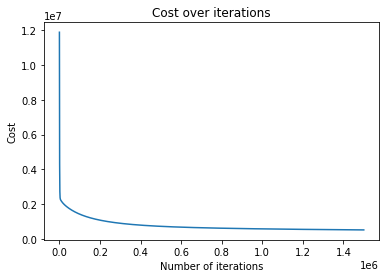

MAE and RMSE on the entire dataset :
MAE : 6084900.7825500155
RMSE : 7341730.346020109

MAE and RMSE on the training set :
MAE : 6062469.790282605
RMSE : 7299238.357174829

MAE and RMSE on the test set :
MAE : 6184766.270914304
RMSE : 7552098.928942025

R² on the entire dataset :
R² : 0.7165999317524311

R² on the training set :
R² : 0.7184413362666469

R² on the test set :
R² : 0.7027612866048392




In [28]:
model_gradient_descent(df_day, 'cnt', normalize=False, delta=0, learning_rate = 0.00001, iterations = 1500000, 
                           test_split=0.15)

print()

#### We can see that our model has decent results and generalizes well. However, to achieve it, the model requires a huge number of iterations. 
#### We chose not to take into account the dataframe with hours because it took to many iterations to predict properly.
#### Also we chose our hyerparameters based on which seemed to work best.

# Test with our normal equation implementation :

In [29]:
print("Results with dataframe without hours :")
print()
model_normal_equation(df_day, 'cnt', normalize=False, test_split=0.15)

print()

Results with dataframe without hours :

Results with normal equation :

Hyperparameters : 
Size of the test set : 15.0 %

Cost : 373945.44874566054

MAE and RMSE on the entire dataset :
MAE : 648.7466385568626
RMSE : 869.3258694594864

MAE and RMSE on the training set :
MAE : 658.0700646738402
RMSE : 864.8068555991687

MAE and RMSE on the test set :
MAE : 596.1116602055625
RMSE : 894.4095627974618

R² on the entire dataset :
R² : 0.7983465443780908

R² on the training set :
R² : 0.802452476275968

R² on the test set :
R² : 0.7734878853653939




#### Once again we see decent result, but a bit better than with our gradient descent implementation

In [30]:
print("Results with dataframe with hours :")
print()
model_normal_equation(df_hour, 'cnt', normalize=False, test_split=0.15)

print()

Results with dataframe with hours :

Results with normal equation :

Hyperparameters : 
Size of the test set : 15.0 %

Cost : 10090.940866157103

MAE and RMSE on the entire dataset :
MAE : 106.10621153029005
RMSE : 141.9297610976971

MAE and RMSE on the training set :
MAE : 106.21420287494959
RMSE : 142.06294989304638

MAE and RMSE on the test set :
MAE : 105.49430200082682
RMSE : 141.17270248680322

R² on the entire dataset :
R² : 0.3877105885532467

R² on the training set :
R² : 0.38839203944576584

R² on the test set :
R² : 0.3834839446582914




#### Compared to our gradient descent, normal equation is clearly faster on the hourly dataset.
#### Moreover, we obtained better results and we could use the dataframe with hours, nevertheless we obtained very weak results on the hourly dataframe.

# Test with scikit-learn :

In [31]:
print("Results with dataframe without hours :")
print()
train, test = split(df_day, 0.15)

print("Results with scikit learn :")

print()
print("On the entire dataset :")
model_with_scikit(df_day, 'cnt', False)
print()
print("On the train set :")
model_with_scikit(train, 'cnt', False)
print()
print("On the test set :")
model_with_scikit(test, 'cnt', False)

Results with dataframe without hours :

Results with scikit learn :

On the entire dataset :
MAE : 648.7802547417148
RMSE : 868.2618702286812
R² : 0.7988398641466312

On the train set :
MAE : 649.4419157585069
RMSE : 873.4744487857034
R² : 0.7946983739027118

On the test set :
MAE : 628.5606168099466
RMSE : 816.5814907157597
R² : 0.8291258996087729


In [32]:
print("Results with dataframe with hours :")
print()
train, test = split(df_hour, 0.15)

print("Results with scikit learn :")

print()
print("On the entire dataset :")
model_with_scikit(df_hour, 'cnt', False)
print()
print("On the train set :")
model_with_scikit(train, 'cnt', False)
print()
print("On the test set :")
model_with_scikit(test, 'cnt', False)

Results with dataframe with hours :

Results with scikit learn :

On the entire dataset :
MAE : 106.0627920057029
RMSE : 141.92536839147877
R² : 0.387748488509715

On the train set :
MAE : 106.18557769155812
RMSE : 141.92134480781758
R² : 0.39010291826575194

On the test set :
MAE : 105.33635081569251
RMSE : 141.8503803117917
R² : 0.37492367677506777


#### With the scikit-learn implementation, we obtained very similar resuts to our normal equation implementation. 

# Analysis of our predictions

#### Since the better results are from our normal equation implementation and scikit-learn implementation, we will take the normal equation results from the dataframe with hours.

In [33]:
weights,_,_,_,_,_,_ = model_normal_equation(df_hour, 'cnt', normalize=False, test_split=0.15)

Results with normal equation :

Hyperparameters : 
Size of the test set : 15.0 %

Cost : 10148.235370019936

MAE and RMSE on the entire dataset :
MAE : 106.0655248845155
RMSE : 141.93642936816278

MAE and RMSE on the training set :
MAE : 106.30535628323852
RMSE : 142.46568267495113

MAE and RMSE on the test set :
MAE : 104.70657228691812
RMSE : 138.89944836277644

R² on the entire dataset :
R² : 0.38765305294858277

R² on the training set :
R² : 0.3872176711031752

R² on the test set :
R² : 0.3901956050572293



## Let's now check the differences between our predictions and reality

In [34]:
matrix = create_matrix(df_hour, 'cnt')
predictions = matrix @ weights

In [35]:
print("Mean of our predictions :", predictions.mean())
print("Mean of the real demand :", df_hour.cnt.mean())

Mean of our predictions : 189.80309152779031
Mean of the real demand : 189.46308763450142


In [36]:
print("Standard deviation of our predictions :", predictions.std())
print("Standard deviation of the real demand :",df_hour.cnt.std())

Standard deviation of our predictions : 113.25855901779431
Standard deviation of the real demand : 181.38759909186527


#### We can see that our predictions are less widespread than the real demand.

## Now the differences with several group by clauses

In [37]:
print("Results with group by :")
print()

index = 1
for i in df_hour.drop('cnt', axis = 1).columns :
    print("Grouped by",i,":")
    matrix = create_matrix(df_hour, 'cnt')
    preds = matrix @ weights
    grouped_df = df_hour.groupby(i, as_index=False).mean()
    
    predictions = np.array([])
    for j in range(grouped_df.shape[0]) :
        value = grouped_df.loc[j, i]
        mask = matrix[:, index] == value
        predictions = np.append(predictions, preds[mask].mean())
    
    index += 1
    print("Mean of our predictions :", int(predictions.mean()))
    print("Mean of the real demand :", int(grouped_df.cnt.mean()))
    print("Standard deviation of our predictions :", int(predictions.std()))
    print("Standard deviation of the real demand :",int(grouped_df.cnt.std()))
    print()
    print()

Results with group by :

Grouped by season :
Mean of our predictions : 188
Mean of the real demand : 188
Standard deviation of our predictions : 50
Standard deviation of the real demand : 53


Grouped by yr :
Mean of our predictions : 189
Mean of the real demand : 189
Standard deviation of our predictions : 44
Standard deviation of the real demand : 64


Grouped by mnth :
Mean of our predictions : 189
Mean of the real demand : 188
Standard deviation of our predictions : 54
Standard deviation of the real demand : 52


Grouped by hr :
Mean of our predictions : 189
Mean of the real demand : 188
Standard deviation of our predictions : 76
Standard deviation of the real demand : 131


Grouped by holiday :
Mean of our predictions : 173
Mean of the real demand : 173
Standard deviation of our predictions : 17
Standard deviation of the real demand : 23


Grouped by weekday :
Mean of our predictions : 189
Mean of the real demand : 189
Standard deviation of our predictions : 7
Standard deviation o

#### From these group bys we can see unconclusive result, dependant on what we group by, we can have higher, lower or somewhat equal values for both the mean and the standard deviation

## Visualizing the differences

In [38]:
def plot_differences(dataframe, group, weights, to_predict, categorical=True) :
    
    df_analysis = dataframe.groupby(group, as_index=False).mean()
    
    
    matrix = create_matrix(dataframe, to_predict)
    preds = matrix @ weights
    preds = preds.flatten()
    
    predictions = np.array([])
    
    index=(dataframe.columns.tolist().index(group))
    for j in range(df_analysis.shape[0]) :
        value = df_analysis[group].loc[j]
        mask = matrix[:, index + 1] == value
        predictions = np.append(predictions, preds[mask].mean())

    plt.title('Real demand (blue) vs Predictions (red) (grouped by '+str(group)+')').set_position([.5, 1.1])
    plt.xlabel(group)
    plt.ylabel("Count")
    if categorical :
        plt.plot(df_analysis[group], predictions, marker='^', c='r')
        plt.bar(df_analysis[group], df_analysis[to_predict])
    else :
        plt.plot(df_analysis[group], df_analysis[to_predict])
        plt.plot(df_analysis[group], predictions, c='r')

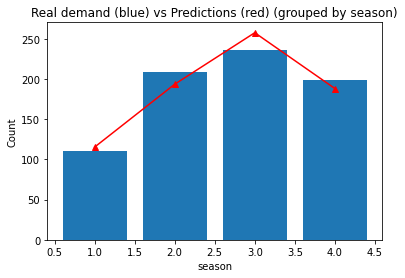

In [39]:
plot_differences(df_hour, 'season', weights, 'cnt')

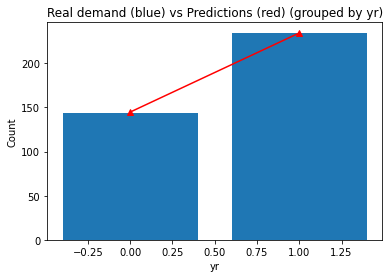

In [40]:
plot_differences(df_hour, 'yr', weights, 'cnt')

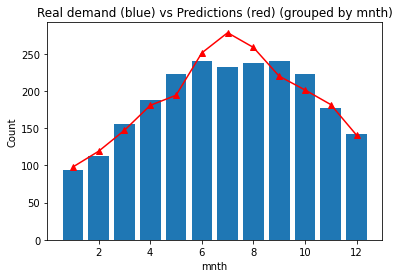

In [41]:
plot_differences(df_hour, 'mnth', weights, 'cnt')

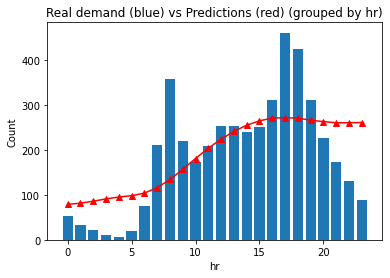

In [42]:
plot_differences(df_hour, 'hr', weights, 'cnt')

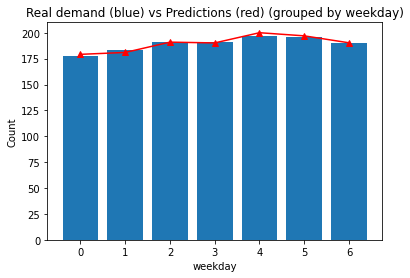

In [43]:
plot_differences(df_hour, 'weekday', weights, 'cnt')

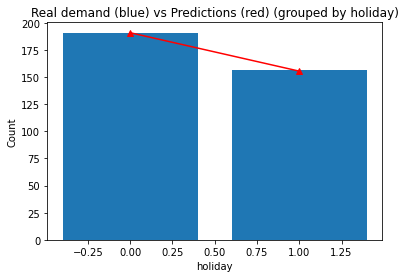

In [44]:
plot_differences(df_hour, 'holiday', weights, 'cnt')

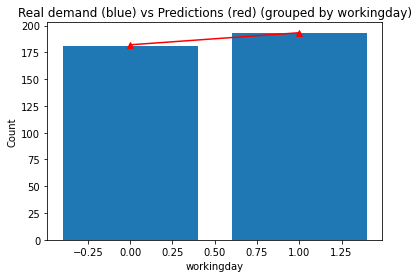

In [45]:
plot_differences(df_hour, 'workingday', weights, 'cnt')

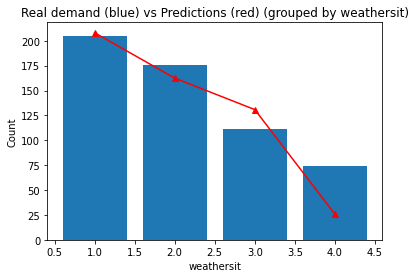

In [46]:
plot_differences(df_hour, 'weathersit', weights, 'cnt')

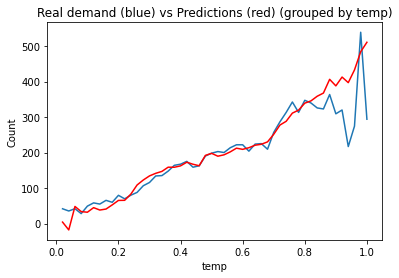

In [47]:
plot_differences(df_hour, 'temp', weights, 'cnt', False)

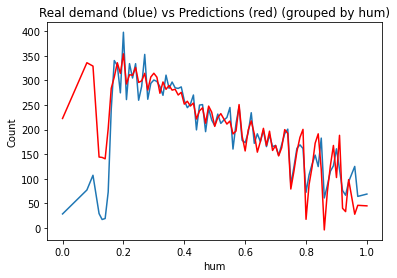

In [48]:
plot_differences(df_hour, 'hum', weights, 'cnt', False)

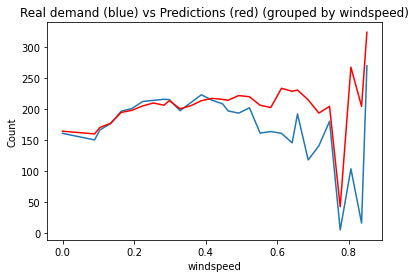

In [49]:
plot_differences(df_hour, 'windspeed', weights, 'cnt', False)

# Feature engineering

#### Let's begin with one hot encoding.

In [50]:
df_hour = pd.get_dummies(df_hour, columns=['season', 'mnth', 'hr', 'weekday', 'weathersit'])

In [51]:
weights,_,_,_,_,_,_ = model_normal_equation(df_hour, 'cnt', normalize=False, test_split=0.15)

print()

Results with normal equation :

Hyperparameters : 
Size of the test set : 15.0 %

Cost : 5152.499139078549

MAE and RMSE on the entire dataset :
MAE : 75.24888583616043
RMSE : 101.65910046176509

MAE and RMSE on the training set :
MAE : 75.15915247901125
RMSE : 101.51353741327853

MAE and RMSE on the test set :
MAE : 75.75734043984573
RMSE : 102.47999702790815

R² on the entire dataset :
R² : 0.6858751236974179

R² on the training set :
R² : 0.6865129926804928

R² on the test set :
R² : 0.6821926088221266




#### Thanks to one hot encoding, we can clearly see an increase in the quality of our model, we made a big leap in from around 0.39 to 0.69.

#### Now let's try to handle the outliers by keeping around 99% of the central data

In [52]:
df_without_outliers = df_hour[ df_hour.cnt < df_hour.cnt.mean () + df_hour.cnt.std () * 3]

In [53]:
print("We removed",df_hour.shape[0] - df_without_outliers.shape[0],"rows in our dataframe.")

We removed 244 rows in our dataframe.


## Re execute the normal equation implementation without the outliers

In [54]:
weights,_,_,_,_,_,_ = model_normal_equation(df_without_outliers, 'cnt', normalize=False, test_split=0.15)

Results with normal equation :

Hyperparameters : 
Size of the test set : 15.0 %

Cost : 4457.495681311326

MAE and RMSE on the entire dataset :
MAE : 70.70072246875017
RMSE : 94.78693609589455

MAE and RMSE on the training set :
MAE : 70.52647031859203
RMSE : 94.41923195314952

MAE and RMSE on the test set :
MAE : 71.68781243954105
RMSE : 96.84352675092711

R² on the entire dataset :
R² : 0.6743302698005479

R² on the training set :
R² : 0.6756670678343066

R² on the test set :
R² : 0.6664186125536555



#### Let's check the metrics and R² to the entire dataframe

In [55]:
compute_metrics(df_hour, 'cnt', weights, False)
compute_R2(df_hour, 'cnt', weights, False)

print()

MAE : 74.60264716682909
RMSE : 102.97802792876782
R² : 0.6776713220557091



#### It seems that the outlier were providing some useful information as the new R² is lower than the previous one
#### So in the end it didn't help us to improve the quality of our model

#### We will now try to add polynomial features

In [56]:
train, test = split(df_hour, test_size = 0.15)

Y_train = create_labels(train, 'cnt')
Y_test = create_labels(test, 'cnt')

train.drop('cnt', axis=1, inplace=True)
test.drop('cnt', axis=1, inplace=True)

poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(train)
X_test = poly.fit_transform(test)

In [57]:
weights = np.linalg.pinv( X_train.T @ X_train ) @ X_train.T @ Y_train

In [58]:
yhat = X_train @ weights

mean_labels = Y_train.mean()

mae = np.sum( abs(yhat - Y_train) ) / X_train.shape[0]    
rmse = np.sqrt( np.sum( (yhat - Y_train)**2 ) / X_train.shape[0])

sst = np.sum( (Y_train - mean_labels)**2 )
ssr = np.sum( (yhat - Y_train)**2 ) 
R2 = 1 - (ssr / sst)

In [59]:
print("Results on the training set with polynomial features:")
print()
print("MAE :",mae)
print("RMSE :",rmse)
print("R² :",R2)

Results on the training set with polynomial features:

MAE : 33.49634828705673
RMSE : 48.73303546889889
R² : 0.9279563078859652


In [60]:
yhat = X_test @ weights

mean_labels = Y_test.mean()

mae = np.sum( abs(yhat - Y_test) ) / X_test.shape[0]    
rmse = np.sqrt( np.sum( (yhat - Y_test)**2 ) / X_test.shape[0])

sst = np.sum( (Y_test - mean_labels)**2 )
ssr = np.sum( (yhat - Y_test)**2 ) 
R2 = 1 - (ssr / sst)

In [61]:
print("Results on the test set with polynomial features:")
print()
print("MAE :",mae)
print("RMSE :",rmse)
print("R² :",R2)

Results on the test set with polynomial features:

MAE : 35.73318660980026
RMSE : 52.0515806307943
R² : 0.9166906285374096


# Conclusion

#### As we can see adding polynomial features improved dramatically the model's quality and we finally have a R² of 0.92

# Optionnal : Other machine learning algorithms

## Linear regression with stochastic gradient descent

In [62]:
sgd = SGDRegressor(max_iter=100000)

sgd.fit(X_train, Y_train.flatten())

predictions = sgd.predict(X_train)
print("Result on the training set with linear regression with stochastic gradient descent :")
print("MAE :",mean_absolute_error(Y_train, predictions))
print("RMSE :",mean_squared_error(Y_train, predictions, squared=False))
print("R² :",sgd.score(X_train, Y_train))
print()

predictions = sgd.predict(X_test)
print("Result on the test set with linear regression with stochastic gradient descent :")
print("MAE :",mean_absolute_error(Y_test, predictions))
print("RMSE :",mean_squared_error(Y_test, predictions, squared=False))
print("R² :",sgd.score(X_test, Y_test))
print()

Result on the training set with linear regression with stochastic gradient descent :
MAE : 34.310241604153134
RMSE : 50.36271081773388
R² : 0.9230573337835535

Result on the test set with linear regression with stochastic gradient descent :
MAE : 36.24354493408914
RMSE : 53.03292969100542
R² : 0.9135196870409088



## Gradient boosting regressor

In [63]:
gbr = GradientBoostingRegressor()

gbr.fit(X_train, Y_train.flatten())

predictions = gbr.predict(X_train)
print("Result on the training set with gradient boosting regressor :")
print("MAE :",mean_absolute_error(Y_train, predictions))
print("RMSE :",mean_squared_error(Y_train, predictions, squared=False))
print("R² :",gbr.score(X_train, Y_train))
print()

predictions = gbr.predict(X_test)
print("Result on the test set with gradient boosting regressor :")
print("MAE :",mean_absolute_error(Y_test, predictions))
print("RMSE :",mean_squared_error(Y_test, predictions, squared=False))
print("R² :",gbr.score(X_test, Y_test))
print()

Result on the training set with gradient boosting regressor :
MAE : 52.350959077641015
RMSE : 69.99754375476174
R² : 0.851367207936125

Result on the test set with gradient boosting regressor :
MAE : 54.64666225656579
RMSE : 73.46351174252058
R² : 0.8340530084656563



## Random forest regressor

In [64]:
rfr = RandomForestRegressor(max_depth=27)

rfr.fit(X_train, Y_train.flatten())

predictions = rfr.predict(X_train)
print("Result on the training set with random forest regressor :")
print("MAE :",mean_absolute_error(Y_train, predictions))
print("RMSE :",mean_squared_error(Y_train, predictions, squared=False))
print("R² :",rfr.score(X_train, Y_train))
print()

predictions = rfr.predict(X_test)
print("Result on the test set with random forest regressor :")
print("MAE :",mean_absolute_error(Y_test, predictions))
print("RMSE :",mean_squared_error(Y_test, predictions, squared=False))
print("R² :",rfr.score(X_test, Y_test))
print()

Result on the training set with random forest regressor :
MAE : 16.8215915981329
RMSE : 25.044973596742686
R² : 0.9809721293239936

Result on the test set with random forest regressor :
MAE : 33.14500701555485
RMSE : 51.11719899314147
R² : 0.9196547677874407



## Deep learning

Epoch 1/15
462/462 [==============================] - 3s 7ms/step - loss: 6428.3955 - mae: 47.9162
Epoch 2/15
462/462 [==============================] - 3s 8ms/step - loss: 2335.0945 - mae: 30.2574
Epoch 3/15
462/462 [==============================] - 4s 8ms/step - loss: 2015.5907 - mae: 28.0055A: 0s - loss: 1984.8998 -
Epoch 4/15
462/462 [==============================] - 3s 7ms/step - loss: 1842.8921 - mae: 26.6477
Epoch 5/15
462/462 [==============================] - 3s 7ms/step - loss: 1736.1365 - mae: 25.7263
Epoch 6/15
462/462 [==============================] - 3s 7ms/step - loss: 1628.2510 - mae: 24.9521
Epoch 7/15
462/462 [==============================] - 3s 7ms/step - loss: 1537.0111 - mae: 24.2257
Epoch 8/15
462/462 [==============================] - 3s 7ms/step - loss: 1459.8949 - mae: 23.4744
Epoch 9/15
462/462 [==============================] - 3s 7ms/step - loss: 1322.4697 - mae: 22.3696
Epoch 10/15
462/462 [==============================] - 3s 7ms/step - loss: 1274.7477

Text(0.5, 0, 'Iterations')

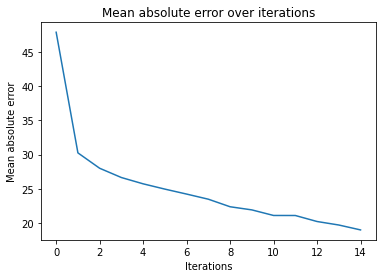

In [65]:
deep_learning = Sequential()

deep_learning.add(Dense(units=X_train.shape[0], activation="relu"))
deep_learning.add(Dense(units=16, activation='relu'))
deep_learning.add(Dense(units=8, activation='relu'))
deep_learning.add(Dense(units=1, activation='relu'))

optimizer = tf.keras.optimizers.Adam()

deep_learning.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

hist = deep_learning.fit(X_train, Y_train, epochs = 15, verbose=1)

plt.plot(hist.history['mae'])
plt.title("Mean absolute error over iterations")
plt.ylabel("Mean absolute error")
plt.xlabel("Iterations")

In [66]:
predictions = deep_learning.predict(X_train)
print("Result on the training set with deep learning :")
print("MAE :",mean_absolute_error(Y_train, predictions))
print("RMSE :",mean_squared_error(Y_train, predictions, squared=False))
mean_labels = Y_train.mean()
sst = np.sum( (Y_train - mean_labels)**2 )
ssr = np.sum( (predictions - Y_train)**2 ) 
R2 = 1 - (ssr / sst)
print("R² :",R2)
print()

predictions = deep_learning.predict(X_test)
print("Result on the test set with deep learning :")
print("MAE :",mean_absolute_error(Y_test, predictions))
print("RMSE :",mean_squared_error(Y_test, predictions, squared=False))
mean_labels = Y_test.mean()
sst = np.sum( (Y_test - mean_labels)**2 )
ssr = np.sum( (predictions - Y_test)**2 ) 
R2 = 1 - (ssr / sst)
print("R² :",R2)
print()

Result on the training set with deep learning :
MAE : 17.230880474454338
RMSE : 28.55693795418433
R² : 0.9752615599466553

Result on the test set with deep learning :
MAE : 26.85402838655436
RMSE : 44.06750319181102
R² : 0.9402878232902331

